# Machine Learning Group Project

In [1]:
# load in the libraries

# data manipulation
import pandas as pd
import numpy as np
 
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# splitting the data
from sklearn.model_selection import train_test_split

# predictive modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# ROC plots
from sklearn.metrics import roc_curve, auc

# model tuning
from sklearn.metrics import mean_squared_error




# EDA 

### Read in CSV

In [2]:
# read in data
df = pd.read_csv('../data/airview_dublincity_measurements_ugm3_csv.zip')

# strip ' UTC' if it's part of the string
df['gps_timestamp'] = df['gps_timestamp'].str.replace(' UTC', '', regex=False)

# convert the cleaned string to pandas datetime format
df['timestamp'] = pd.to_datetime(df['gps_timestamp'], format="%Y-%m-%d %H:%M:%S")



## Plots

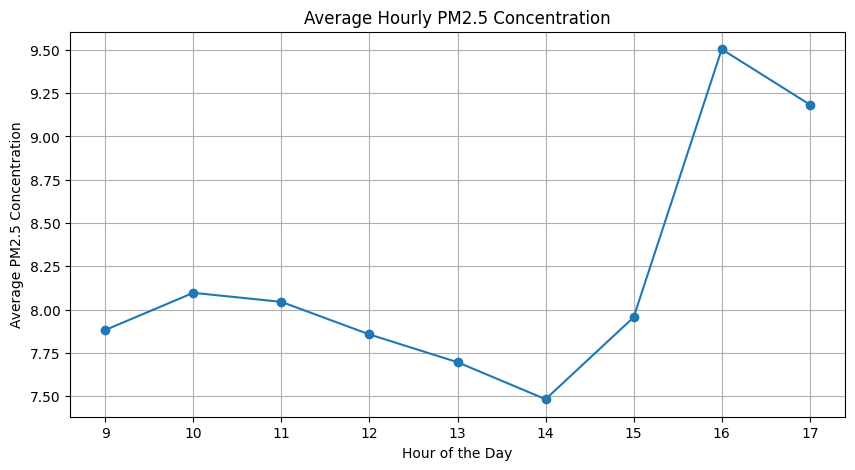

In [3]:
# Create the hour_float column
df['hour_float'] = df['timestamp'].dt.hour + df['timestamp'].dt.minute / 60

# extract just the hour component
df['hour'] = df['timestamp'].dt.hour

# group by hour and get average PM2.5
hourly_avg = df.groupby('hour')['PM25_ugm3'].mean().reset_index()

# filter for 9 AM to 5 PM only 
hourly_avg = hourly_avg[(hourly_avg['hour'] >= 9) & (hourly_avg['hour'] <= 17)]

# create plot
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg['hour'], hourly_avg['PM25_ugm3'], marker='o')
plt.xlabel("Hour of the Day")
plt.ylabel("Average PM2.5 Concentration")
plt.title("Average Hourly PM2.5 Concentration")
plt.grid(True)

plt.show()


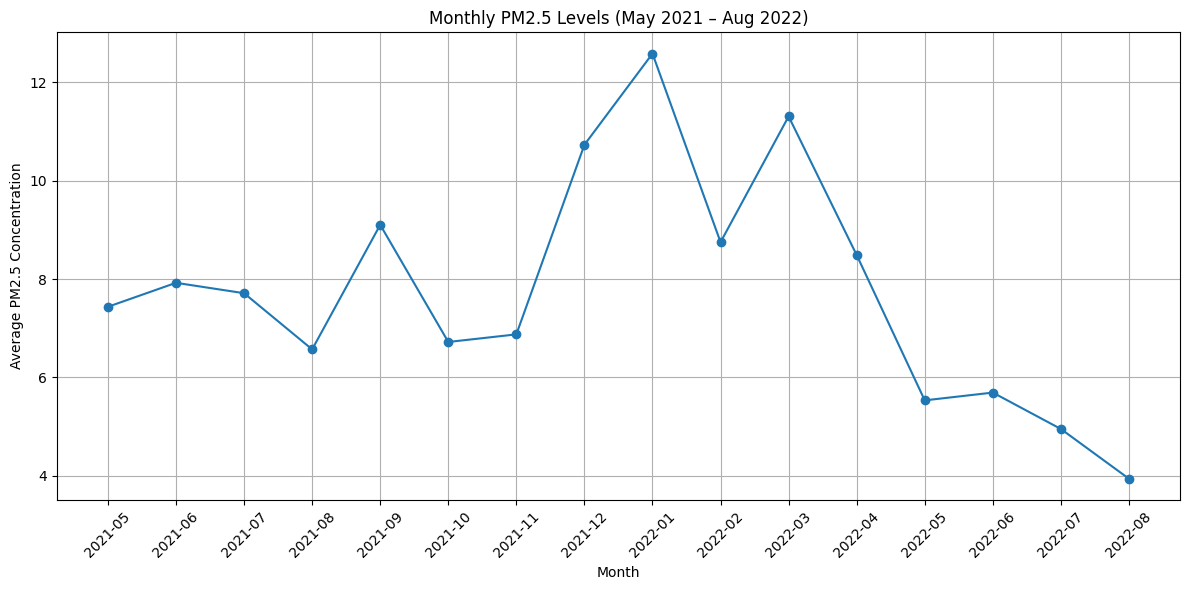

In [4]:
# create a 'year-month' column
df['year_month'] = df['timestamp'].dt.to_period('M').astype(str)

# group and calculate average for PM2.5
monthly_avg = df.groupby('year_month')['PM25_ugm3'].mean()

# create plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Average PM2.5 Concentration")
plt.title("Monthly PM2.5 Levels (May 2021 – Aug 2022)")
plt.grid(True)
plt.tight_layout()
plt.show()


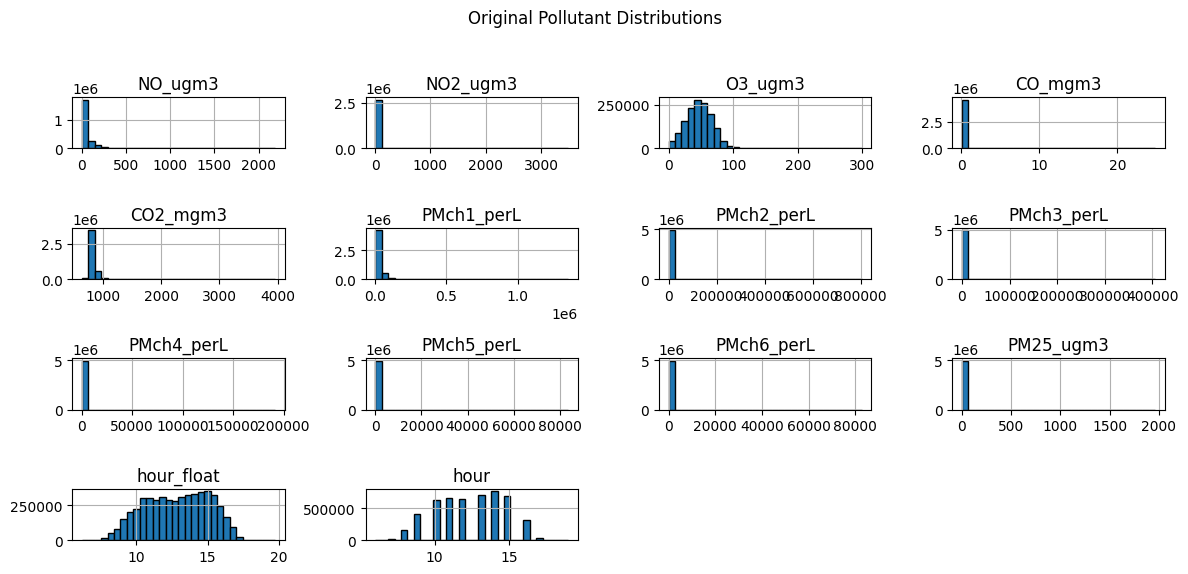

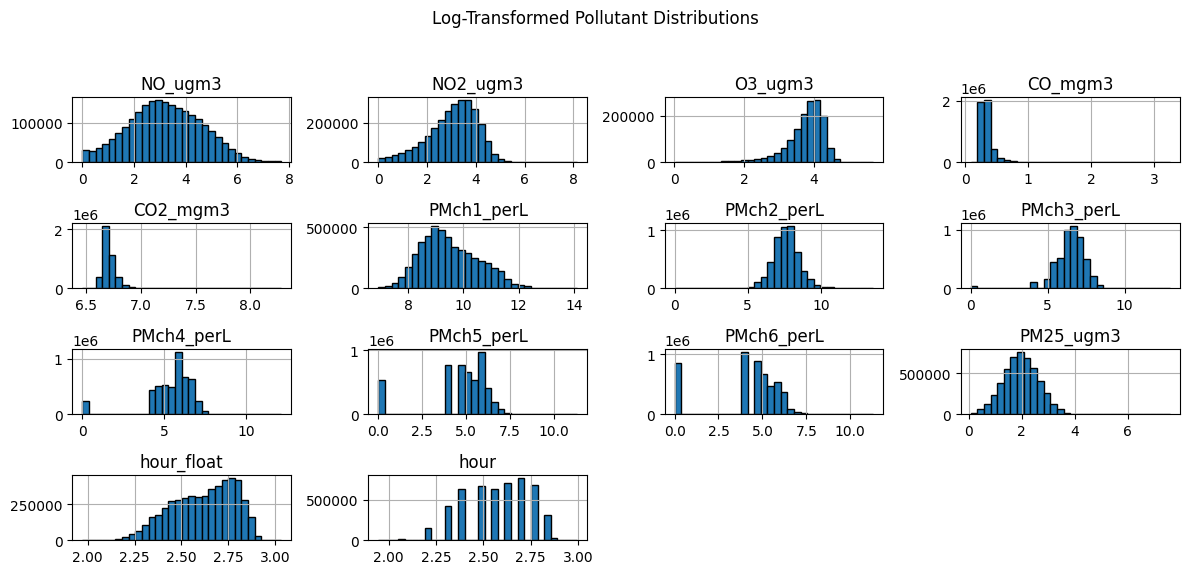

In [5]:
# Select only numeric columns
df_excl = df.drop(columns=['latitude', 'longitude', 'gps_timestamp'])

numeric_cols = df_excl.select_dtypes(include=[np.number])

# Copy and clean for original 
numeric_clean = numeric_cols.copy()
numeric_clean = numeric_clean.map(lambda x: np.nan if x < 0 else x)

# Log-transformed version
df_log = np.log1p(numeric_clean)

# Plot: Original 
numeric_clean.hist(figsize=(12, 6), bins=30, edgecolor="black")
plt.suptitle("Original Pollutant Distributions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot: Log-transformed
df_log.hist(figsize=(12, 6), bins=30, edgecolor="black")
plt.suptitle("Log-Transformed Pollutant Distributions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Descriptive Statistics

In [6]:
# Subset
pollutants = ['PM25_ugm3', 'NO2_ugm3', 'CO2_mgm3', 'O3_ugm3', 'NO_ugm3', 'CO_mgm3']

# Summary table 
summary_df = pd.DataFrame(columns=['Variable', 'Count', 'Missing %', 'Mean', 'SD'])

for var in pollutants:
    total = len(df)
    non_missing = df[var].count()
    missing_pct = 100 * (1 - non_missing / total)
    mean_val = df[var].mean()
    std_val = df[var].std()

    summary_df.loc[len(summary_df)] = [
        var.replace('_ugm3', '').replace('_mgm3', '').replace('PM25', 'PM2.5').replace('CO2', 'CO₂').replace('NO2', 'NO₂').replace('O3', 'O₃'),
        f"{non_missing:,}",  # formatted with commas
        f"{missing_pct:.1f}%",
        f"{mean_val:.2f}",
        f"{std_val:.2f}"
    ]

# Print table
print(summary_df)


  Variable      Count Missing %    Mean      SD
0    PM2.5  4,940,266      1.8%    7.98    8.55
1      NO₂  3,865,035     23.2%   18.32   34.64
2      CO₂  4,131,647     17.9%  816.65   52.71
3       O₃  1,447,372     71.2%   46.83   20.35
4       NO  4,611,444      8.3%   20.94  103.19
5       CO  4,708,874      6.4%    0.42    0.24


# Predictive Modelling

In [7]:
display(df)

,gps_timestamp,latitude,longitude,NO_ugm3,NO2_ugm3,O3_ugm3,CO_mgm3,CO2_mgm3,PMch1_perL,PMch2_perL,PMch3_perL,PMch4_perL,PMch5_perL,PMch6_perL,PM25_ugm3,timestamp,hour_float,hour,year_month
0,2022-04-07 14:56:36,53.346434,-6.263997,-13.526,11.724,NaN,0.293,765.328,6240.0,1860.0,1380.0,480.0,60.0,120.0,4.927,2022-04-07 14:56:36,14.933333,14,2022-04
1,2022-04-07 14:56:37,53.346434,-6.263997,-29.957,4.441,NaN,0.291,NaN,4800.0,1380.0,1020.0,240.0,240.0,60.0,4.240,2022-04-07 14:56:37,14.933333,14,2022-04
2,2022-04-07 14:56:38,53.346434,-6.263997,-9.260,8.725,59.109,0.299,NaN,6300.0,1800.0,1140.0,600.0,60.0,60.0,4.204,2022-04-07 14:56:38,14.933333,14,2022-04
3,2022-04-07 14:56:39,53.346434,-6.263997,-22.847,7.023,NaN,0.295,NaN,5040.0,1800.0,1080.0,300.0,60.0,60.0,3.410,2022-04-07 14:56:39,14.933333,14,2022-04
4,2022-04-07 14:56:40,53.346434,-6.263997,-9.225,15.591,NaN,0.296,763.271,5580.0,1920.0,1260.0,480.0,60.0,60.0,4.003,2022-04-07 14:56:40,14.933333,14,2022-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5030138,2022-04-07 14:56:31,53.346434,-6.263997,-13.114,5.921,NaN,0.304,771.618,5940.0,1440.0,720.0,600.0,120.0,60.0,4.169,2022-04-07 14:56:31,14.933333,14,2022-04
5030139,2022-04-07 14:56:32,53.346434,-6.263997,-22.120,5.064,NaN,0.304,771.599,5460.0,1380.0,960.0,480.0,180.0,120.0,5.207,2022-04-07 14:56:32,14.933333,14,2022-04
5030140,2022-04-07 14:56:33,53.346434,-6.263997,-17.668,4.208,56.223,0.297,769.511,5340.0,1860.0,840.0,240.0,240.0,0.0,3.463,2022-04-07 14:56:33,14.933333,14,2022-04
5030141,2022-04-07 14:56:34,53.346434,-6.263997,-7.020,5.286,NaN,0.303,767.451,5160.0,1800.0,900.0,420.0,120.0,120.0,4.740,2022-04-07 14:56:34,14.933333,14,2022-04


In [8]:
# select only partical polution variable
partical_polution = df.loc[:, list(df.columns[0:3]) + ['PM25_ugm3']]

# convert to datetime
partical_polution['gps_timestamp'] = pd.to_datetime(partical_polution['gps_timestamp'],  utc=True)

# remove utc and floor to the nearest hour
partical_polution['gps_timestamp'] = partical_polution['gps_timestamp'].dt.tz_localize(None).dt.floor('h')

# display the data
display(partical_polution)

,gps_timestamp,latitude,longitude,PM25_ugm3
0,2022-04-07 14:00:00,53.346434,-6.263997,4.927
1,2022-04-07 14:00:00,53.346434,-6.263997,4.240
2,2022-04-07 14:00:00,53.346434,-6.263997,4.204
3,2022-04-07 14:00:00,53.346434,-6.263997,3.410
4,2022-04-07 14:00:00,53.346434,-6.263997,4.003
...,...,...,...,...
5030138,2022-04-07 14:00:00,53.346434,-6.263997,4.169
5030139,2022-04-07 14:00:00,53.346434,-6.263997,5.207
5030140,2022-04-07 14:00:00,53.346434,-6.263997,3.463
5030141,2022-04-07 14:00:00,53.346434,-6.263997,4.740


# External Factors
https://data.gov.ie/en_GB/dataset/dcc-scats-detector-volume-jul-dec-2022

In [9]:
# read in the data for july's traffic volume 
# other months are available but for simplicity we will only use july
july_car_data = pd.read_csv("../data/scatsjuly2022.zip")

# filter for the city centre
july_car_data = july_car_data[july_car_data['Region'] == 'CCITY'][['End_Time','Site', 'Detector', 'Sum_Volume', 'Avg_Volume']]

# group the data by site
july_car_data = july_car_data.groupby(['End_Time', 'Site']).mean('Avg_Volume').reset_index().round(2)

# display the data
display(july_car_data)

,End_Time,Site,Detector,Sum_Volume,Avg_Volume
0,20220701000000,1,15.5,6.06,0.31
1,20220701000000,2,5.0,100.75,8.12
2,20220701000000,3,12.5,41.83,3.42
3,20220701000000,17,7.5,81.57,6.43
4,20220701000000,19,12.5,21.08,1.50
...,...,...,...,...,...
89420,20220731230000,936,12.5,38.88,3.12
89421,20220731230000,941,12.5,2.00,0.12
89422,20220731230000,956,4.5,2.12,0.00
89423,20220731230000,958,1.5,1.50,0.00


### Add the location to the traffic volumes

In [10]:
# read in the data
SCAT_Sites = pd.read_csv('../data/dcc_traffic_signals_20221130.csv')

# merge the locations with the readings
df = pd.merge(SCAT_Sites, july_car_data, left_on='SiteID', right_on='Site', how='right')

# filter only the useful columns
df = df.loc[:,['Lat','Long','End_Time','Sum_Volume', 'Avg_Volume']]

# convert the time to dt format
df['End_Time'] = pd.to_datetime(df['End_Time'], format='%Y%m%d%H%M%S')

# group the readings around the city by time and take the mean - 2d.p.
df = df.groupby(['End_Time'])[['Sum_Volume', 'Avg_Volume']].mean().reset_index().round(2)

display(df)


,End_Time,Sum_Volume,Avg_Volume
0,2022-07-01 00:00:00,43.74,3.46
1,2022-07-01 01:00:00,32.71,2.53
2,2022-07-01 02:00:00,27.67,2.14
3,2022-07-01 03:00:00,23.09,1.77
4,2022-07-01 04:00:00,18.96,1.42
...,...,...,...
739,2022-07-31 19:00:00,64.10,5.26
740,2022-07-31 20:00:00,59.79,4.90
741,2022-07-31 21:00:00,51.48,4.33
742,2022-07-31 22:00:00,45.24,3.56


### Merge the two DataFrames together

In [11]:
# merge the data in location
df = pd.merge(partical_polution, df, 
                left_on='gps_timestamp', right_on='End_Time', how='left').groupby(['End_Time', 
                                                                                    'longitude', 
                                                                                    'latitude'])[['PM25_ugm3',
                                                                                                  'Sum_Volume',
                                                                                                  'Avg_Volume']].mean().reset_index()
# show the data
display(df)

,End_Time,longitude,latitude,PM25_ugm3,Sum_Volume,Avg_Volume
0,2022-07-11 09:00:00,-6.255150,53.345477,7.535,66.85,5.35
1,2022-07-11 09:00:00,-6.255150,53.345437,5.073,66.85,5.35
2,2022-07-11 09:00:00,-6.255149,53.345515,5.676,66.85,5.35
3,2022-07-11 09:00:00,-6.255149,53.345551,4.876,66.85,5.35
4,2022-07-11 09:00:00,-6.255148,53.345401,5.310,66.85,5.35
...,...,...,...,...,...,...
184507,2022-07-29 12:00:00,-6.271836,53.342619,6.502,68.64,5.51
184508,2022-07-29 12:00:00,-6.271806,53.342850,4.230,68.64,5.51
184509,2022-07-29 12:00:00,-6.271776,53.342703,7.248,68.64,5.51
184510,2022-07-29 12:00:00,-6.271770,53.342810,4.896,68.64,5.51


## Add 'Bad Polution Bool'

In [12]:
# introduce new boolean term for bad pollution with PM > 5
# value of 5 is taken from the literature
df['bad_pollution'] = (df['PM25_ugm3'] > 5).astype(int)

# look at the data
display(df)

,End_Time,longitude,latitude,PM25_ugm3,Sum_Volume,Avg_Volume,bad_pollution
0,2022-07-11 09:00:00,-6.255150,53.345477,7.535,66.85,5.35,1
1,2022-07-11 09:00:00,-6.255150,53.345437,5.073,66.85,5.35,1
2,2022-07-11 09:00:00,-6.255149,53.345515,5.676,66.85,5.35,1
3,2022-07-11 09:00:00,-6.255149,53.345551,4.876,66.85,5.35,0
4,2022-07-11 09:00:00,-6.255148,53.345401,5.310,66.85,5.35,1
...,...,...,...,...,...,...,...
184507,2022-07-29 12:00:00,-6.271836,53.342619,6.502,68.64,5.51,1
184508,2022-07-29 12:00:00,-6.271806,53.342850,4.230,68.64,5.51,0
184509,2022-07-29 12:00:00,-6.271776,53.342703,7.248,68.64,5.51,1
184510,2022-07-29 12:00:00,-6.271770,53.342810,4.896,68.64,5.51,0


# Add the Weather Data
https://www.met.ie/climate/available-data/historical-data


In [13]:
# read in the weather data
# skip first 15 admin rows
weather = pd.read_csv('../data/hly175.csv', skiprows=15, low_memory=False)

# convert to dt
weather['date'] = pd.to_datetime(weather['date'],  format='%d-%b-%Y %H:%M')

# show the data
display(weather)

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,2003-08-16 01:00:00,0,0.0,0,9.2,0,8.9,8.5,11.1,95,1021.9
1,2003-08-16 02:00:00,0,0.0,0,9.0,0,8.7,8.5,11.1,96,1021.7
2,2003-08-16 03:00:00,0,0.0,0,8.2,0,8.0,7.7,10.5,96,1021.2
3,2003-08-16 04:00:00,0,0.0,0,8.4,0,8.1,7.9,10.7,97,1021.2
4,2003-08-16 05:00:00,0,0.0,0,7.7,0,7.5,7.3,10.2,97,1021.1
...,...,...,...,...,...,...,...,...,...,...,...
188827,2025-02-28 20:00:00,0,0.0,0,6.0,0,3.6,-0.4,5.9,63,1028.6
188828,2025-02-28 21:00:00,0,0.0,0,4.4,0,2.7,-0.2,6.0,71,1029.0
188829,2025-02-28 22:00:00,0,0.0,0,4.1,0,2.7,0.4,6.3,76,1029.4
188830,2025-02-28 23:00:00,0,0.0,0,2.8,0,1.7,-0.2,6.0,80,1029.6


In [14]:
# merge the data
data = pd.merge(df, weather, left_on='End_Time', right_on='date', how='left')

# remove useless collumns
data.drop(columns={'End_Time', 'latitude', 'longitude'}, inplace=True)

# ensure all the data is numeric
for col in data.columns:
    if col != 'date':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# show the data
display(data)

,PM25_ugm3,Sum_Volume,Avg_Volume,bad_pollution,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,7.535,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
1,5.073,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
2,5.676,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
3,4.876,66.85,5.35,0,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
4,5.310,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184507,6.502,68.64,5.51,1,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6
184508,4.230,68.64,5.51,0,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6
184509,7.248,68.64,5.51,1,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6
184510,4.896,68.64,5.51,0,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6


# Plot the data

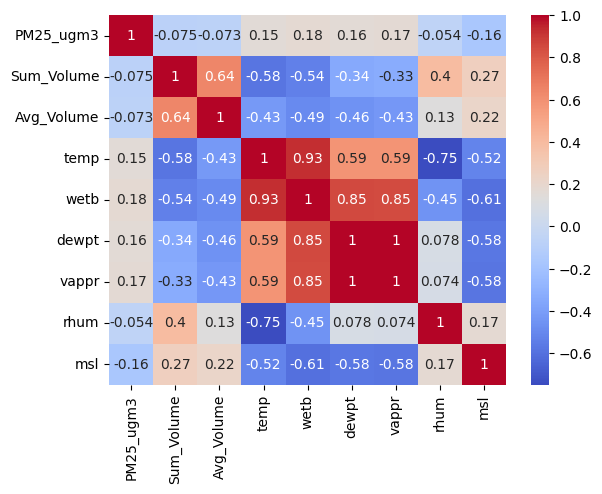

In [15]:
# plot heat map of variables
sns.heatmap(data[['PM25_ugm3', 'Sum_Volume', 'Avg_Volume', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']].corr(), annot=True, cmap='coolwarm')
plt.show()

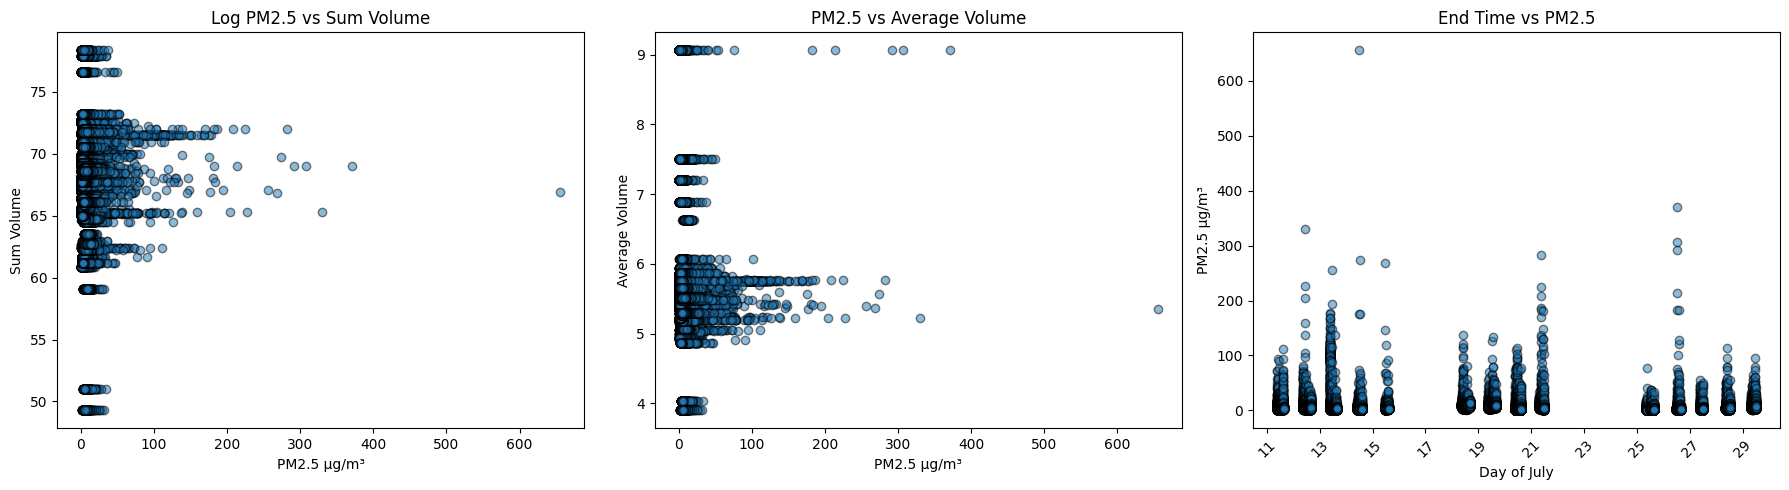

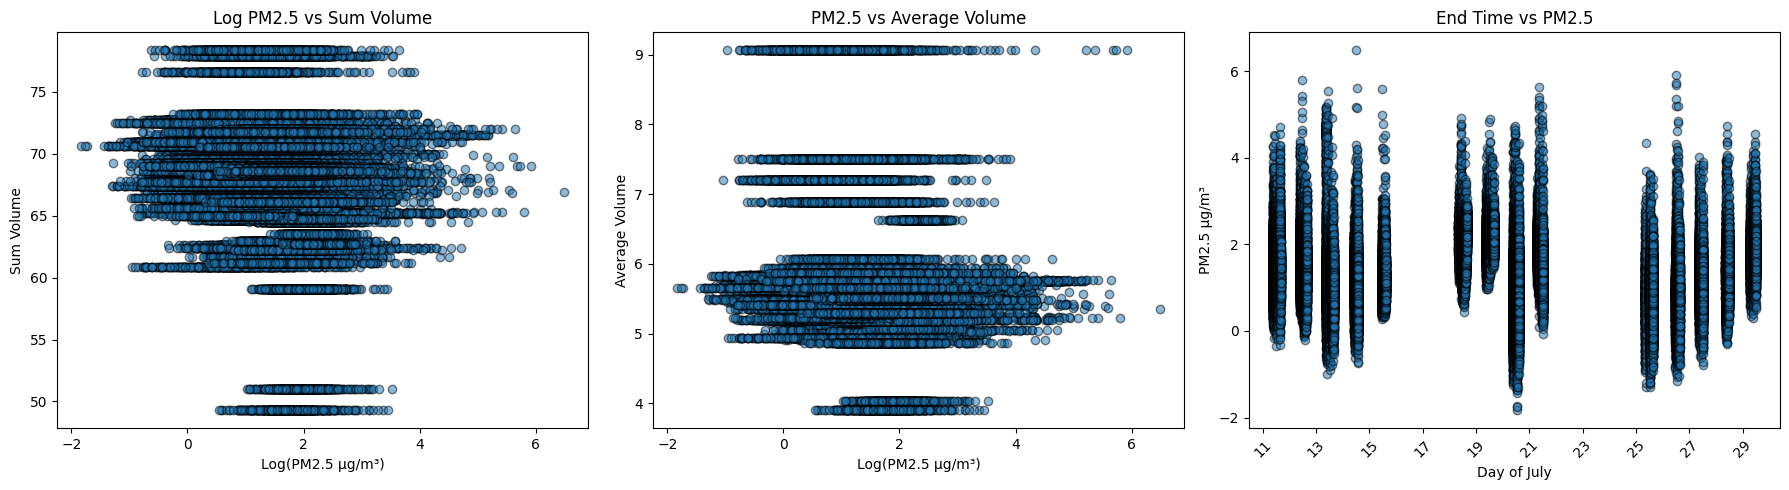

In [16]:
# define the subplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# First scatter plot
axes[0].scatter(data['PM25_ugm3'], data['Sum_Volume'] ,alpha=0.5, edgecolors='k')
axes[0].set_xlabel('PM2.5 µg/m³')
axes[0].set_ylabel('Sum Volume')
axes[0].set_title('Log PM2.5 vs Sum Volume')

# Second scatter plot
axes[1].scatter(data['PM25_ugm3'], data['Avg_Volume'], alpha=0.5, edgecolors='k')
axes[1].set_xlabel('PM2.5 µg/m³')
axes[1].set_ylabel('Average Volume')
axes[1].set_title('PM2.5 vs Average Volume')

# Third scatter plot
axes[2].scatter(data['date'], data['PM25_ugm3'], alpha=0.5, edgecolors='k')
axes[2].set_xlabel('Day of July')
axes[2].set_ylabel('PM2.5 µg/m³')
axes[2].set_title('End Time vs PM2.5')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()




fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# First scatter plot
axes[0].scatter(np.log(data['PM25_ugm3']), data['Sum_Volume'], alpha=0.5, edgecolors='k')
axes[0].set_xlabel('Log(PM2.5 µg/m³)')
axes[0].set_ylabel('Sum Volume')
axes[0].set_title('Log PM2.5 vs Sum Volume')

# Second scatter plot
axes[1].scatter(np.log(data['PM25_ugm3']), data['Avg_Volume'], alpha=0.5, edgecolors='k')
axes[1].set_xlabel('Log(PM2.5 µg/m³)')
axes[1].set_ylabel('Average Volume')
axes[1].set_title('PM2.5 vs Average Volume')

# Third scatter plot
axes[2].scatter(data['date'], np.log(data['PM25_ugm3']), alpha=0.5, edgecolors='k')
axes[2].set_xlabel('Day of July')
axes[2].set_ylabel('PM2.5 µg/m³')
axes[2].set_title('End Time vs PM2.5')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()


# Cleaning the data

### Log the polution variable

In [17]:
# applying log ensures the var follows a normal distribution
data['PM25_ugm3'] = np.log(data['PM25_ugm3'])

### Checking the balance of 'GOOD' vs 'BAD' Pollution days

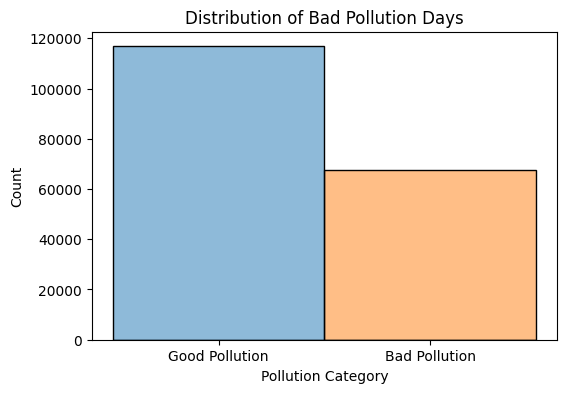

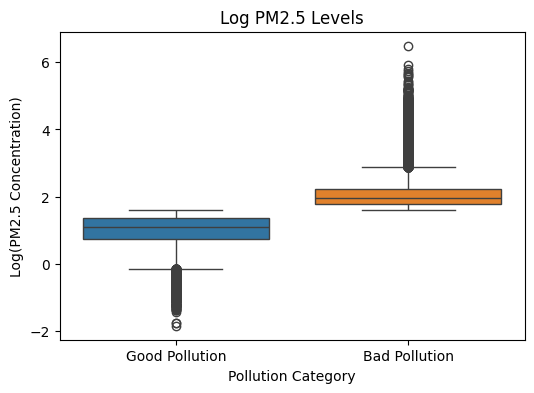

In [18]:
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x='bad_pollution', bins=2, discrete=True, hue='bad_pollution', palette='tab10', legend=False)
plt.xticks([0, 1], ['Good Pollution', 'Bad Pollution'])
plt.xlabel('Pollution Category')
plt.ylabel('Count')
plt.title('Distribution of Bad Pollution Days')
plt.show()


plt.figure(figsize=(6, 4))
sns.boxplot(data = data, x='bad_pollution', y='PM25_ugm3', palette='tab10', legend=False, hue='bad_pollution')
plt.xticks([0, 1], ['Good Pollution', 'Bad Pollution'])
plt.xlabel('Pollution Category')
plt.ylabel('Log(PM2.5 Concentration)')
plt.title('Log PM2.5 Levels')
plt.show()




### Removing Outliers & NAs

In [19]:
# remove data outside 3std of the mean
def remove_outliers(df, col):
    mean = np.mean(df[col])
    std = np.std(df[col])
    return df[(df[col] > mean - 3 * std) & (df[col] < mean + 3 * std)]

# check the original length
original_len = len(data)

# define the columns to clean
cols = ['PM25_ugm3', 'Avg_Volume', 'Sum_Volume', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']#, 'ind',	'rain',	'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']

# apply the function to the columns
for col in cols:
    data = remove_outliers(data, col)

# Remove rows with NaN values in any column
data = data.dropna()

# check how many were removed
print(f'we see that {original_len - len(data)} data points have been removed')
display(data)
# doing this should help improve the model performance

we see that 6841 data points have been removed


,PM25_ugm3,Sum_Volume,Avg_Volume,bad_pollution,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,2.019559,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
1,1.623932,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
2,1.736247,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
3,1.584325,66.85,5.35,0,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
4,1.669592,66.85,5.35,1,2022-07-11 09:00:00,0,0.0,0,21.7,0,16.3,12.2,14.2,54,1022.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184507,1.872110,68.64,5.51,1,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6
184508,1.442202,68.64,5.51,0,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6
184509,1.980726,68.64,5.51,1,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6
184510,1.588419,68.64,5.51,0,2022-07-29 12:00:00,0,0.0,0,19.8,0,16.3,13.8,15.8,68,1017.6


## Normalising the Data

In [20]:
# normalising function
def norm(df, col):
    minim = df[col].min()
    maxim = df[col].max()
    df[col] = (df[col] - minim) / (maxim - minim)
    return df.round(2)


# define the columns to clean
cols = ['PM25_ugm3', 'Avg_Volume', 'Sum_Volume', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']

# apply the function to the columns
for col in cols:
    data = norm(data, col)

# display the data
display(data)

,PM25_ugm3,Sum_Volume,Avg_Volume,bad_pollution,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl
0,0.66,0.40,0.18,1,2022-07-11 09:00:00,0,0.0,0,0.38,0,0.52,0.58,0.50,0.43,0.77
1,0.56,0.40,0.18,1,2022-07-11 09:00:00,0,0.0,0,0.38,0,0.52,0.58,0.50,0.43,0.77
2,0.59,0.40,0.18,1,2022-07-11 09:00:00,0,0.0,0,0.38,0,0.52,0.58,0.50,0.43,0.77
3,0.55,0.40,0.18,0,2022-07-11 09:00:00,0,0.0,0,0.38,0,0.52,0.58,0.50,0.43,0.77
4,0.57,0.40,0.18,1,2022-07-11 09:00:00,0,0.0,0,0.38,0,0.52,0.58,0.50,0.43,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184507,0.62,0.49,0.24,1,2022-07-29 12:00:00,0,0.0,0,0.27,0,0.52,0.72,0.66,0.71,0.51
184508,0.51,0.49,0.24,0,2022-07-29 12:00:00,0,0.0,0,0.27,0,0.52,0.72,0.66,0.71,0.51
184509,0.65,0.49,0.24,1,2022-07-29 12:00:00,0,0.0,0,0.27,0,0.52,0.72,0.66,0.71,0.51
184510,0.55,0.49,0.24,0,2022-07-29 12:00:00,0,0.0,0,0.27,0,0.52,0.72,0.66,0.71,0.51


# Plot the cleaned data

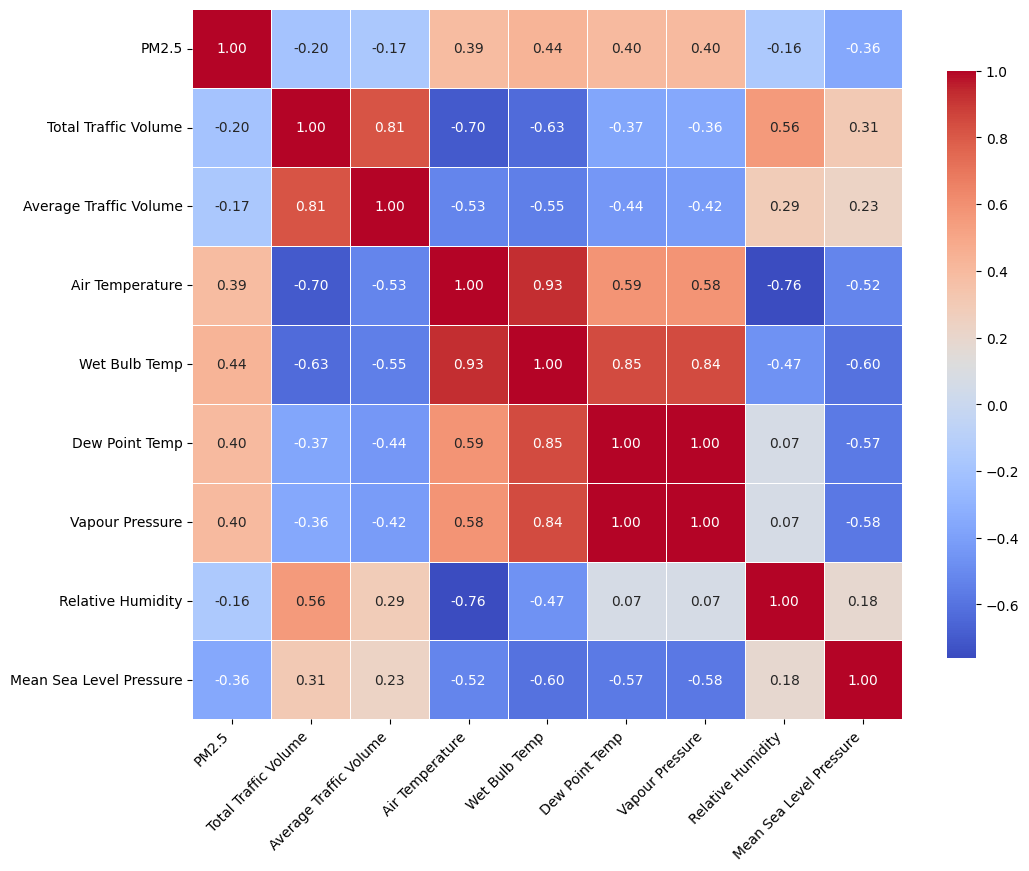

In [21]:

# define mapping of variable names to full labels
label_map = {
    'PM25_ugm3': 'PM2.5',
    'Sum_Volume': 'Total Traffic Volume',
    'Avg_Volume': 'Average Traffic Volume',
    'temp': 'Air Temperature',
    'wetb': 'Wet Bulb Temp',
    'dewpt': 'Dew Point Temp',
    'vappr': 'Vapour Pressure',
    'rhum': 'Relative Humidity',
    'msl': 'Mean Sea Level Pressure'
}

# select and rename the data for the heatmap
selected_data = data[['PM25_ugm3', 'Sum_Volume', 'Avg_Volume', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']]
renamed_data = selected_data.rename(columns=label_map)

# compute correlation matrix
corr_matrix = renamed_data.corr()

# figure size
plt.figure(figsize=(11, 9))

# plot the heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

# Add title and adjust tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


# ------------------------------------------------------------------------------------------
# Predictive Models
# ------------------------------------------------------------------------------------------

### Define the variables

In [22]:
# define the feature columns
X = data[['Sum_Volume', 'Avg_Volume', 'temp', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl']]

# define the target variable
y = data['bad_pollution']


# split the data into test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### Train the model

In [23]:

# define and fit the logistic regression to the training data
logit = LogisticRegression(random_state=1)
logit.fit(X_train, y_train)

# evaluate the model on the test data
train_score = logit.score(X_train, y_train)
test_score = logit.score(X_test, y_test)

# print the scores
print(f'Train = {round(train_score, 3)}', f'\nTest  = {round(test_score,3)}')

Train = 0.762 
Test  = 0.76


In [24]:
random_forest = RandomForestClassifier(max_depth=5, random_state=1)
random_forest.fit(X_train, y_train)


train_score = random_forest.score(X_train, y_train)
test_score = random_forest.score(X_test, y_test)

# print the scores
print(f'Train = {round(train_score, 3)}', f'\nTest  = {round(test_score,3)}')

Train = 0.799 
Test  = 0.793


In [25]:
xgboost = XGBClassifier(random_state=1, learning_rate=0.01)
xgboost.fit(X_train, y_train)

train_score = xgboost.score(X_train, y_train)
test_score = xgboost.score(X_test, y_test)

# print the scores
print(f'Train = {round(train_score, 3)}', f'\nTest  = {round(test_score,3)}')


# Train = 0.795 
# Test  = 0.789

Train = 0.795 
Test  = 0.789


In [26]:
d_tree = DecisionTreeClassifier(random_state=1)

d_tree.fit(X_train, y_train)

train_score = d_tree.score(X_train, y_train)
test_score = d_tree.score(X_test, y_test)

# print the scores
print(f'Train = {round(train_score, 3)}', f'\nTest  = {round(test_score,3)}')

Train = 0.8 
Test  = 0.795


# Evaluate the models

In [27]:
# model eval funciton
def eval_model(model, X_test, y_test):

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # define confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # extract coeffs from confusion matrix
    TP = cm[1, 1]  # true positives
    FP = cm[0, 1]  # false positives
    FN = cm[1, 0]  # false negatives
    TN = cm[0, 0]  # true negatives

    # plot the conf matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, 
                                        cmap='Blues',
                                        values_format='d')
    plt.title(f'{model.__class__.__name__} Confusion Matrix') 
    plt.show() 

    # calculating f1 scores
    precision = TP / (TP + FP)  
    accuracy = (TP + TN) / (TP + FP + TN + FN) 
    recall = TP / (TP + FN)  
    f1 = 2 * (precision * recall) / (precision + recall) 

    # print the results
    print(f'Precision Score: {round(precision,2)} \nAccuracy score: {round(accuracy,2)} \nF1 Score: {round(f1,2)}')



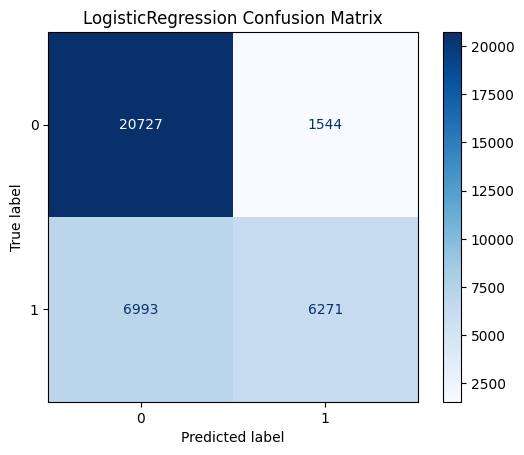

Precision Score: 0.8 
Accuracy score: 0.76 
F1 Score: 0.59


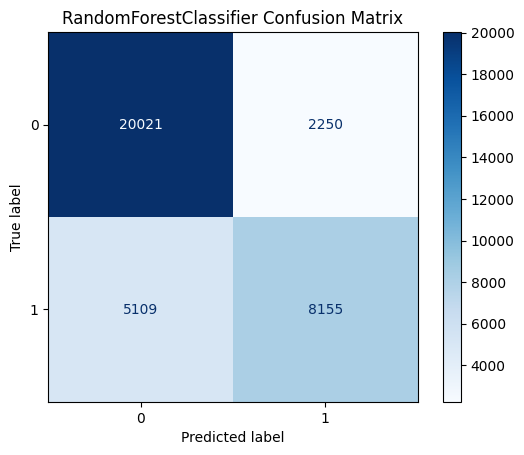

Precision Score: 0.78 
Accuracy score: 0.79 
F1 Score: 0.69


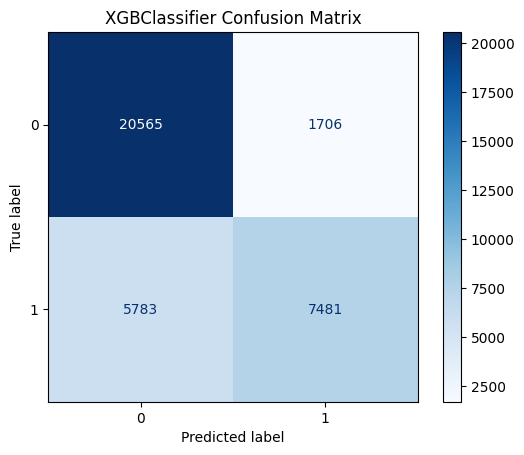

Precision Score: 0.81 
Accuracy score: 0.79 
F1 Score: 0.67


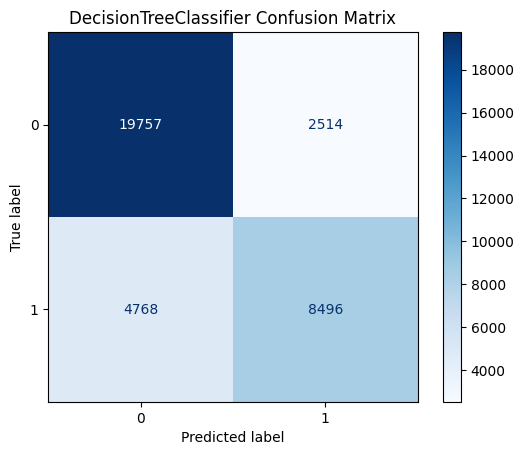

Precision Score: 0.77 
Accuracy score: 0.8 
F1 Score: 0.7


In [28]:
# evaluate the models
eval_model(logit, X_test, y_test)
eval_model(random_forest, X_test, y_test)
eval_model(xgboost, X_test, y_test)
eval_model(d_tree, X_test, y_test)

## ROC Curve

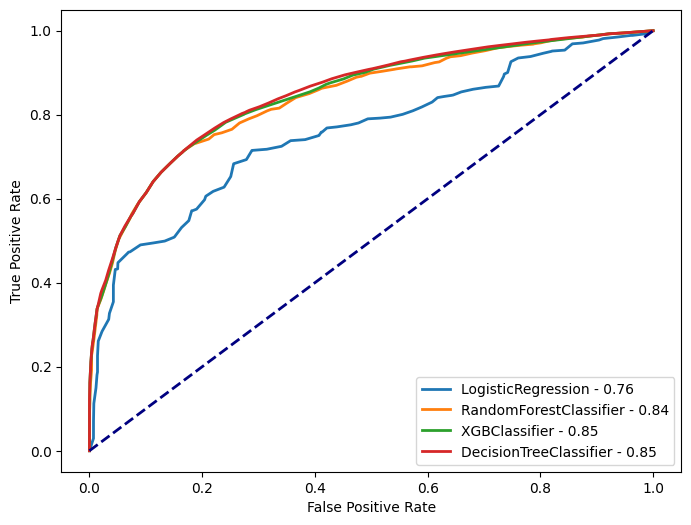

In [29]:
# List of models
models = [logit, random_forest, xgboost, d_tree]

plt.figure(figsize=(8, 6))

# Loop through models to plot each ROC curve
for model in models:

    # predict probabilities 
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model.__class__.__name__} - {round(roc_auc, 2)}')

# diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


## Feature Importance

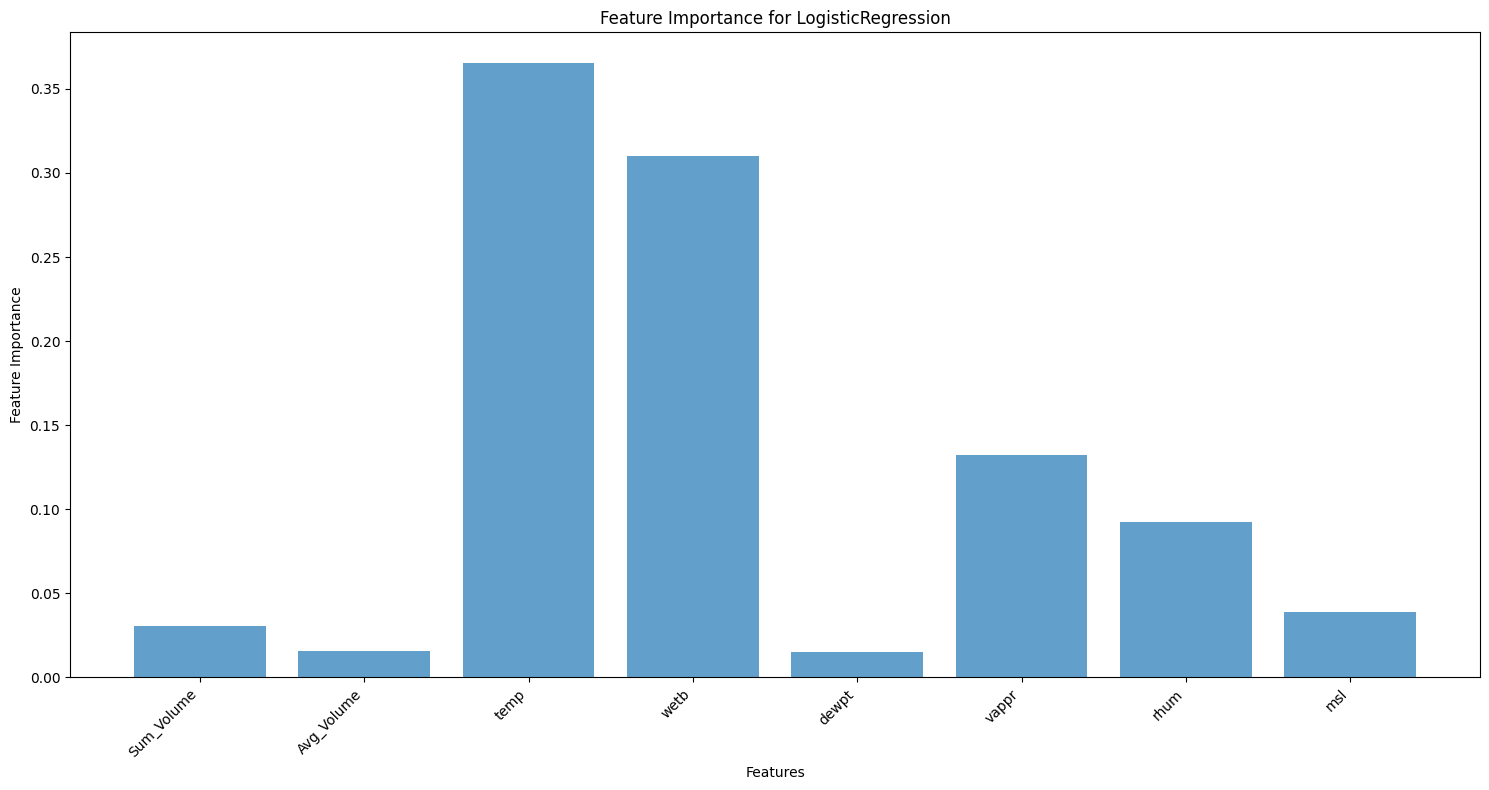

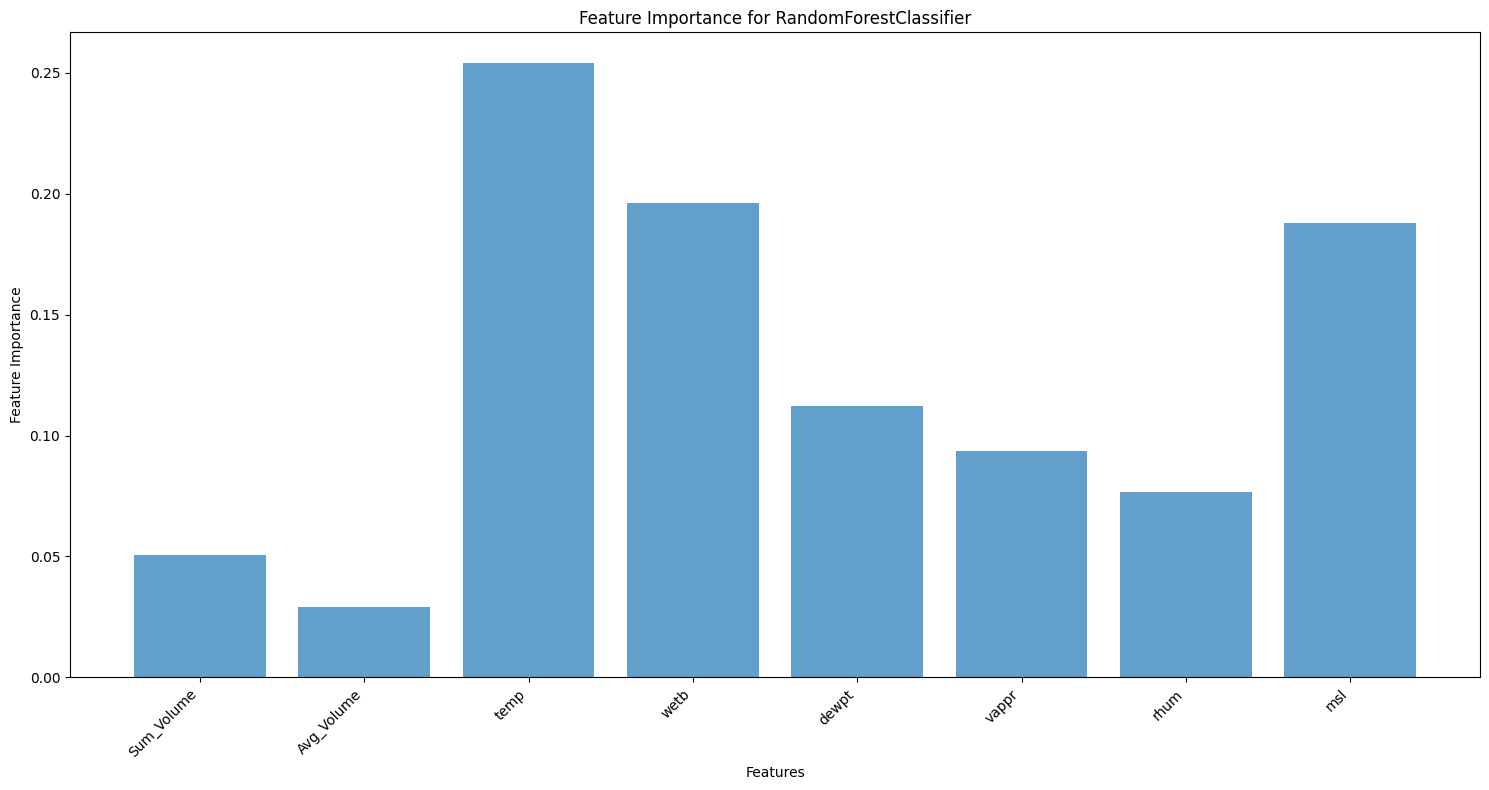

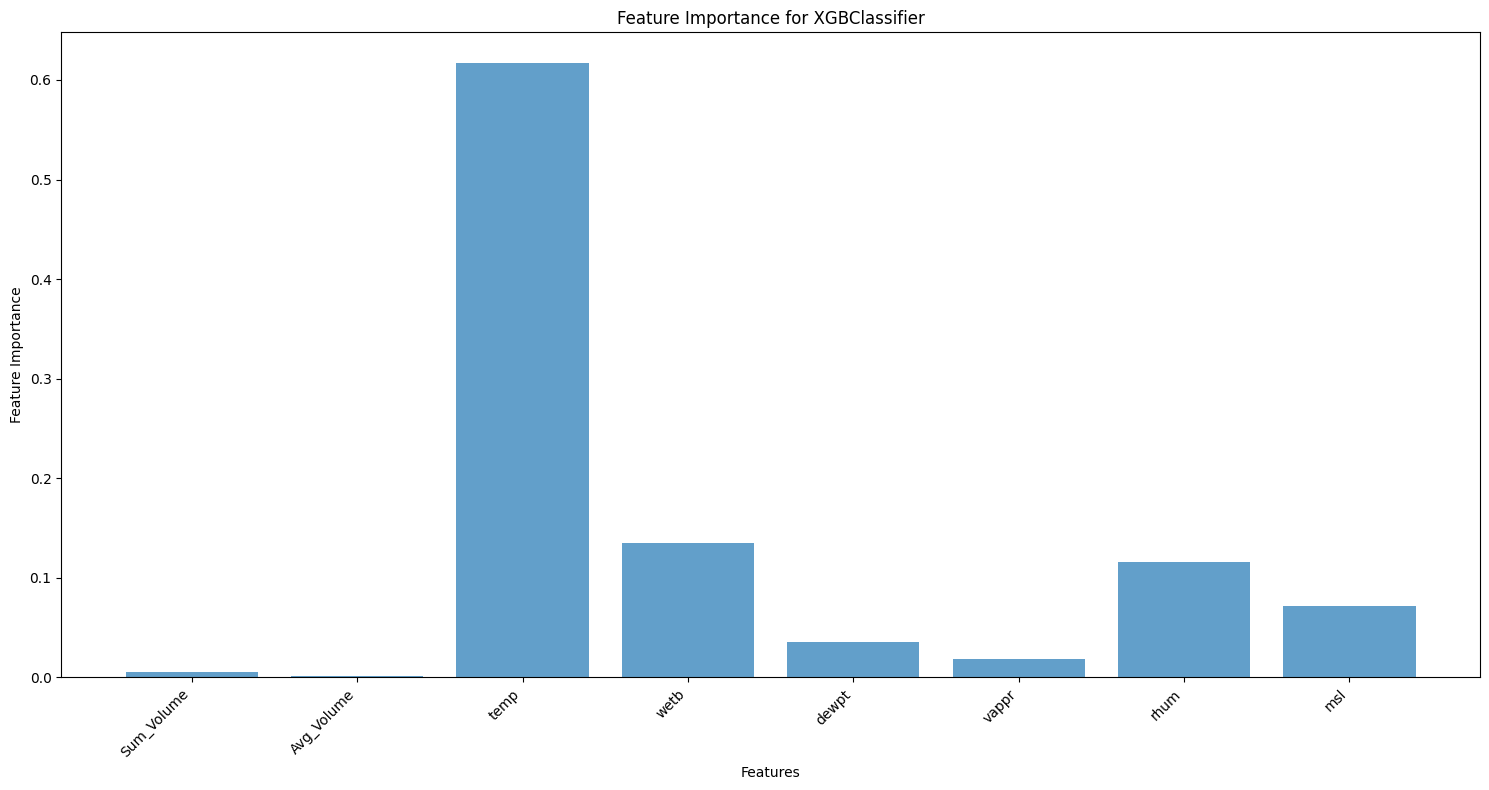

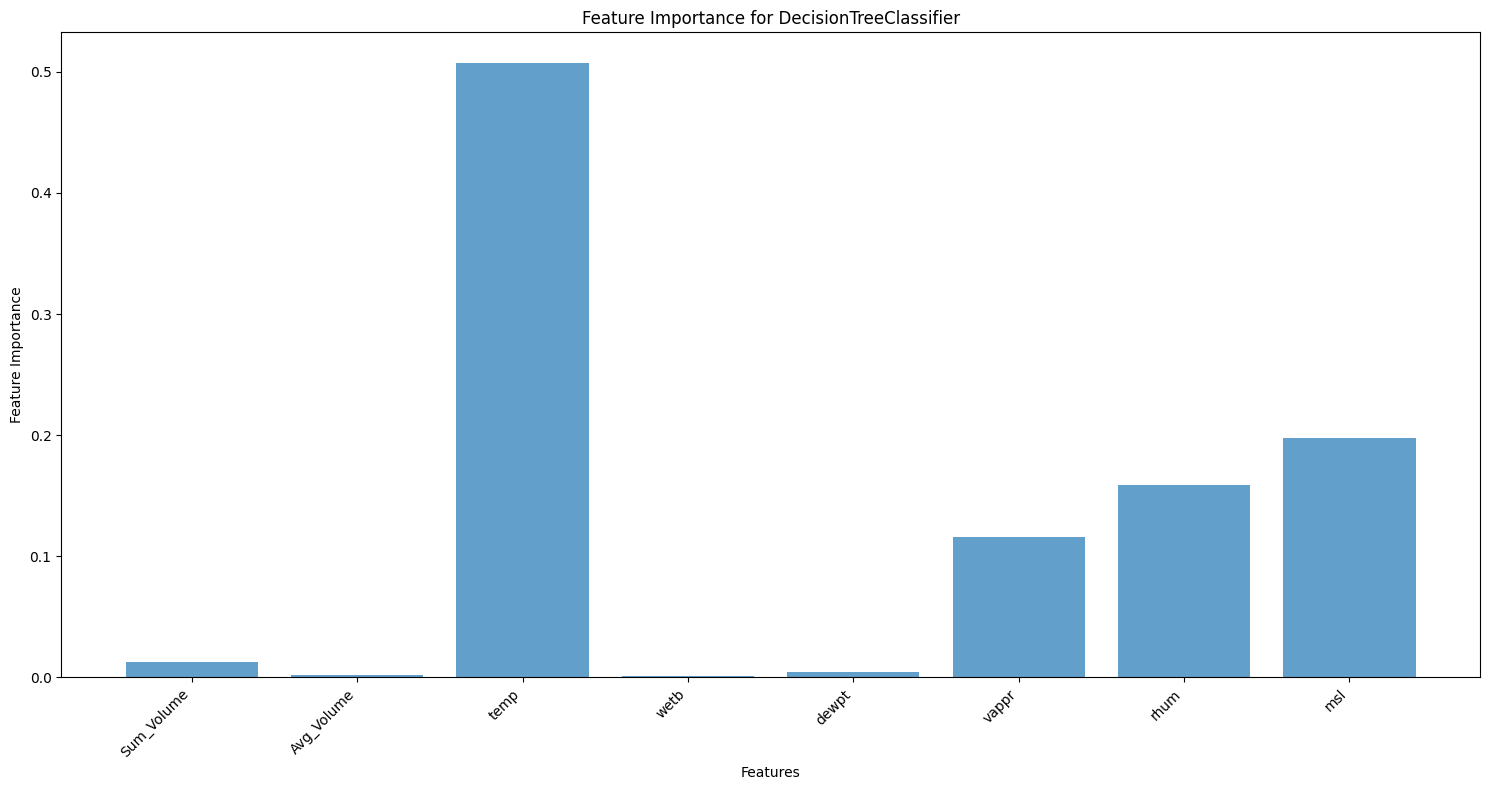

In [30]:
# extract feature importance
def plot_feature_importance(model, X_train, feature_names):
    # Create a new figure for each model
    plt.figure(figsize=(15, 8))

    # For Logistic Regression: Use coefficients as feature importance
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    
    # For Random Forest and Decision Tree: Use feature_importances_
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    
    # For XGBoost: Use get_booster().get_score() method
    elif hasattr(model, 'get_booster'):
        importance = model.get_booster().get_score(importance_type='weight')
        importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        importance = np.array([x[1] for x in importance])

    # Normalize to get the feature importance as percentages
    importance = importance / np.sum(importance)

    # Plotting the feature importance as a bar chart
    plt.bar(feature_names, importance, alpha=0.7)
    
    # Labeling the plot
    plt.xlabel('Features')
    plt.ylabel('Feature Importance')
    plt.title(f'Feature Importance for {model.__class__.__name__}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show the plot for the current model
    plt.show()

# List of models to evaluate
models = [logit, random_forest, xgboost, d_tree]

# Get feature names from the training data
feature_names = X_train.columns

# Call the function to plot feature importance for each model
for model in models:
    plot_feature_importance(model, X_train, feature_names)


### Combined plot

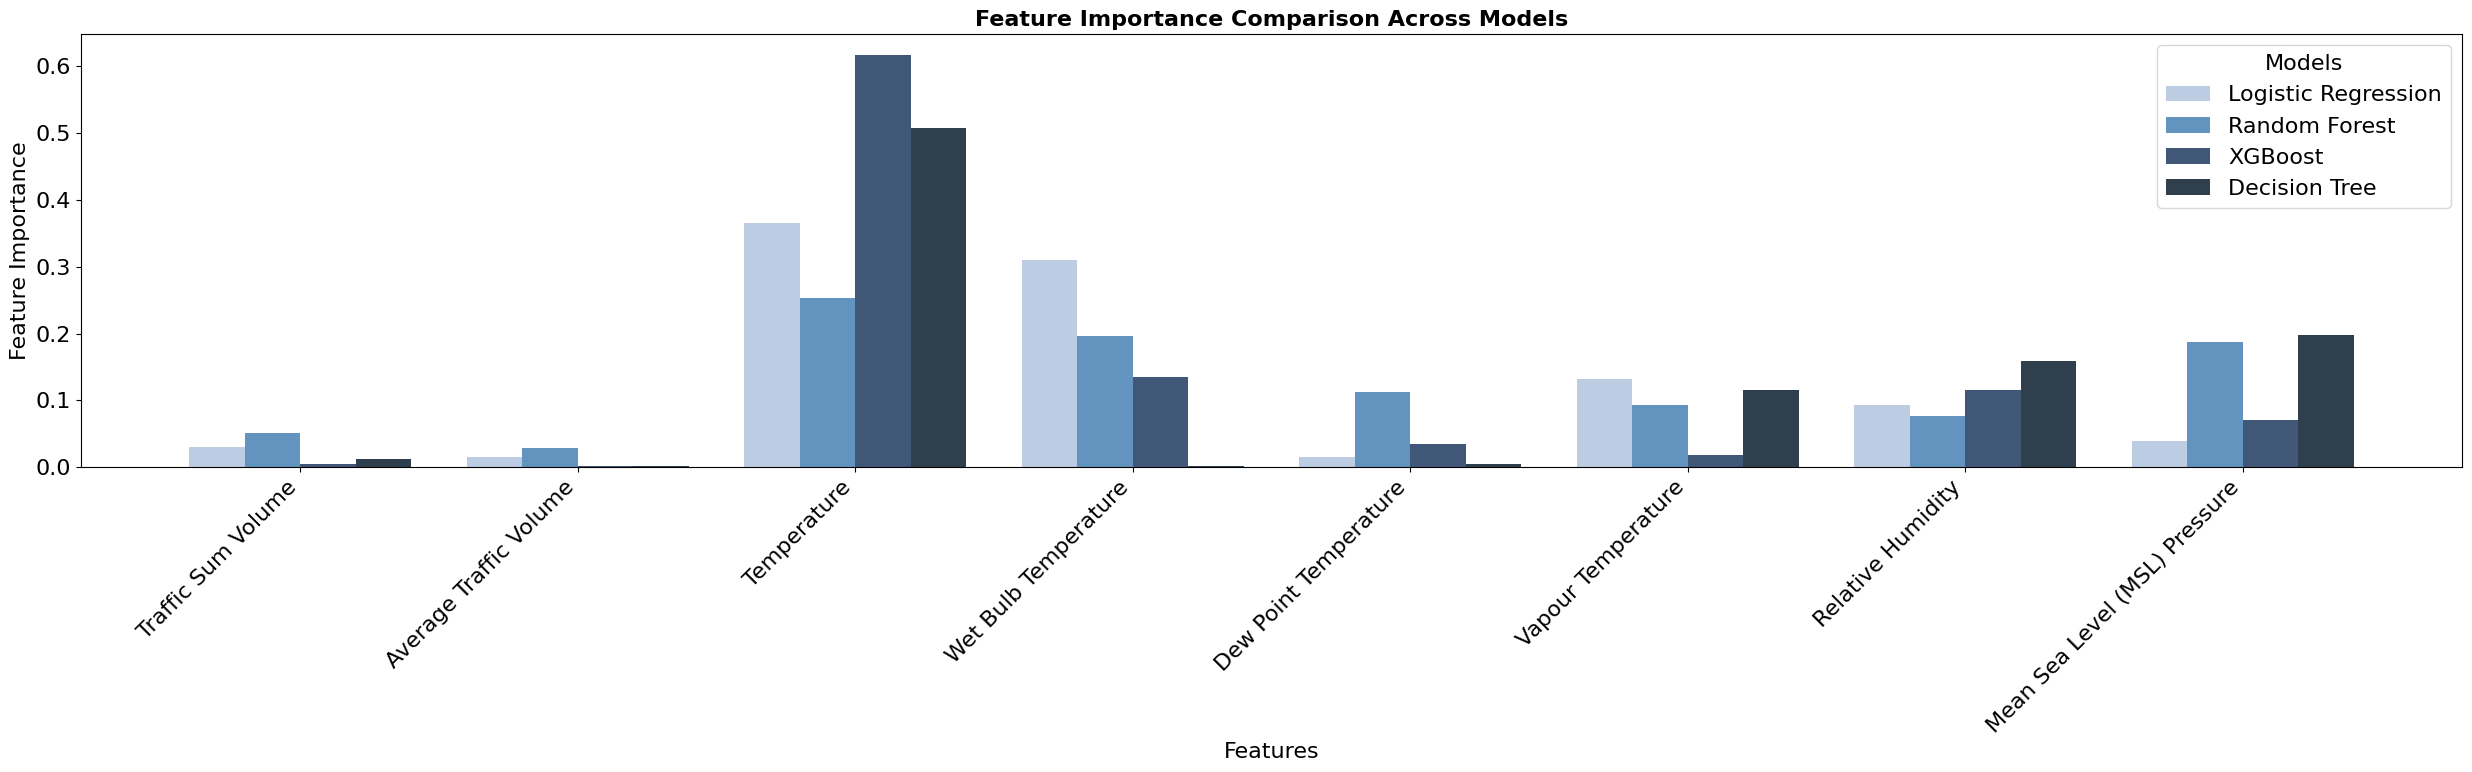

In [31]:
# adjust the font size
plt.rcParams.update({'font.size': 16})  


# Extract feature importance
def get_feature_importance(model, X_train, feature_names):
    # For Logistic Regression: Use coefficients as feature importance
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    
    # For Random Forest and Decision Tree: Use feature_importances_
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    
    # For XGBoost: Use get_booster().get_score() method
    elif hasattr(model, 'get_booster'):
        importance = model.get_booster().get_score(importance_type='weight')
        importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        importance = np.array([x[1] for x in importance])

    # Normalize to get the feature importance as percentages
    importance = importance / np.sum(importance)
    
    return importance

# List of models to evaluate
models = [logit, random_forest, xgboost, d_tree]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Decision Tree']

# Get feature names from the training data
feature_names = X_train.columns

# Define a blue colour palette
blue_palette = ['#B0C4DE', '#4682B4', '#1E3A5F', '#0A1D2F']

# Set up the figure
plt.figure(figsize=(25, 8))

# Loop through each model and plot the feature importance
for i, model in enumerate(models):
    importance = get_feature_importance(model, X_train, feature_names)
    
    # Offset each model's bars to group them together
    bar_width = 0.2
    x_pos = np.arange(len(feature_names)) + i * bar_width
    
    plt.bar(x_pos, importance, width=bar_width, alpha=0.85, color=blue_palette[i], label=model_names[i])

# Adding labels, title, and legend
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Comparison Across Models', fontsize=16, weight='bold')
xticks_pos = np.arange(len(feature_names)) + bar_width * (len(models) - 1) / 2
xticks_labels = ['Traffic Sum Volume', 'Average Traffic Volume', 'Temperature', 'Wet Bulb Temperature', 'Dew Point Temperature', 'Vapour Temperature', 'Relative Humidity', 'Mean Sea Level (MSL) Pressure']  # Use feature names as labels

# Set the custom x-ticks
plt.xticks(xticks_pos, xticks_labels, rotation=45, ha='right')
plt.legend(title="Models")
plt.tight_layout()

# Show the plot
plt.show()


# Tuning the models


### XGBoost

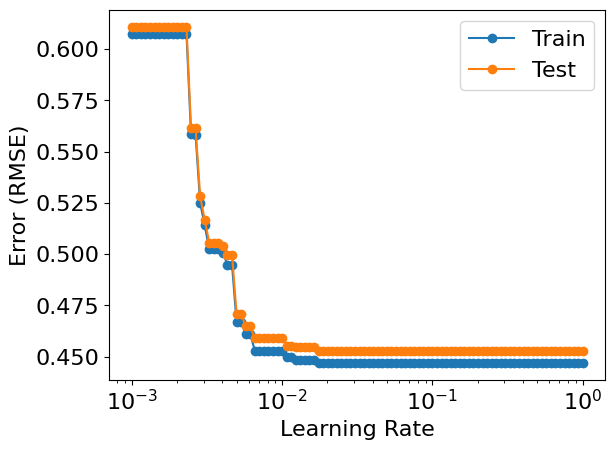

In [32]:

# Define the range of learning rates (just like the alphas in Ridge regression)
learning_rates = np.logspace(-3, 0, 100)

train_errors = []
test_errors = []

# Loop over each learning rate value
for lr in learning_rates:
    # Initialize the XGBoost classifier with the current learning rate
    xgboost = XGBClassifier(learning_rate=lr, random_state=1, n_estimators=100)  # You can also tune n_estimators
    xgboost.fit(X_train, y_train)
    
    # Make predictions
    train_preds = xgboost.predict(X_train)
    test_preds = xgboost.predict(X_test)
    
    # Calculate RMSE for train and test
    train_error = np.sqrt(mean_squared_error(y_train, train_preds))
    test_error = np.sqrt(mean_squared_error(y_test, test_preds))

    # Append the errors to the lists
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot the errors against the learning rates
plt.plot(learning_rates, train_errors, '-o', label='Train')
plt.plot(learning_rates, test_errors, '-o', label='Test')
plt.xscale('log')  # Use logarithmic scale for x-axis (like alpha in Ridge)
plt.legend()
plt.ylabel('Error (RMSE)')
plt.xlabel('Learning Rate')


plt.show()


### Decision Tree

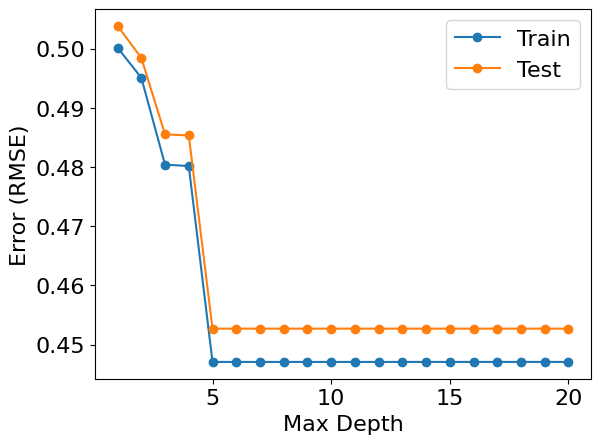

In [33]:

# Define the range of max_depth values (similar to alpha for Ridge regression)
max_depth_values = np.arange(1, 21)  # Depth values from 1 to 20

train_errors = []
test_errors = []

# Loop over each max_depth value
for depth in max_depth_values:
    # Initialize the Decision Tree with the current max_depth
    tree = DecisionTreeClassifier(max_depth=depth, random_state=1)
    tree.fit(X_train, y_train)
    
    # Make predictions
    train_preds = tree.predict(X_train)
    test_preds = tree.predict(X_test)
    
    # Calculate RMSE for train and test
    train_error = np.sqrt(mean_squared_error(y_train, train_preds))
    test_error = np.sqrt(mean_squared_error(y_test, test_preds))

    # Append the errors to the lists
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot the errors against the max_depth values
plt.plot(max_depth_values, train_errors, '-o', label='Train')
plt.plot(max_depth_values, test_errors, '-o', label='Test')
plt.legend()
plt.ylabel('Error (RMSE)')
plt.xlabel('Max Depth')

plt.show()
